In [1]:
import sys
sys.path.append('/home/ec2-user/SageMaker')
from toniutils import dirtoni as dirt
from toniutils import printoni

<h2>Load Data</h2>

In [1]:
from script import load

In [2]:
path = 'engineered_data/experiment-1/'
X_train, X_val, Y_train, Y_val = [load(path + i + '.pkl') for i in ('X_train', 'X_val', 'Y_train', 'Y_val')]

<h2>Train Model</h2>

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
from tensorflow import float32 as fl32
from tensorflow import random_normal as rnorm
from tensorflow import matmul, add
from tensorflow.nn import relu,dropout, tanh
from tensorflow.initializers import he_uniform, glorot_uniform
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [5]:
batch_size = 1

In [6]:
inputs = tf.placeholder(shape = [batch_size, X_train.shape[1]], dtype = fl32, name = 'inputs')
labels = tf.placeholder(shape = [batch_size, Y_train.shape[1]], dtype = fl32, name = 'labels')

In [ ]:
printoni(dirt(tf.initializers), 4)

In [ ]:
with tf.variable_scope('l1', reuse = tf.AUTO_REUSE):
    w1 = tf.get_variable('w1', [inputs.shape[1].value, 110], initializer = he_uniform())
    b1 = tf.get_variable('b1', [110,], initializer = tf.initializers.zeros)
    layer1 = dropout( relu(add(matmul(inputs, w1), b1), name = 'relu'), rate = 0.1 )

with tf.variable_scope('l2', reuse = tf.AUTO_REUSE):
    w2 = tf.get_variable('w2', [layer1.shape[1].value, 220], initializer = he_uniform())
    b2 = tf.get_variable('b2', [220,], initializer = tf.initializers.zeros)
    layer2 = dropout( relu(add(matmul(layer1, w2), b2), name = 'relu'), rate = 0.1)

with tf.variable_scope('l3', reuse = tf.AUTO_REUSE):
    w3 = tf.get_variable('w3', [layer2.shape[1].value, 220], initializer = he_uniform())
    b3 = tf.get_variable('b3', [220,], initializer = tf.initializers.zeros)
    layer3 = dropout( relu(add(matmul(layer2, w3), b3), name = 'relu'), rate = 0.1)
    
'''with tf.variable_scope('l4', reuse = tf.AUTO_REUSE):
    w4 = tf.get_variable('w4', [layer3.shape[1].value, 220], initializer = he_uniform())
    b4 = tf.get_variable('b4', [220,], initializer = tf.initializers.zeros)
    layer4 = dropout( relu(add(matmul(layer3, w4), b4), name = 'relu'), rate = 0.1)'''

with tf.variable_scope('output_layer', reuse = tf.AUTO_REUSE):
    w_out = tf.get_variable('w_out', [layer3.shape[1].value, 80], initializer = glorot_uniform())
    b_out = tf.get_variable('b_out', [80,], initializer = tf.initializers.zeros)
    layer_out = add(matmul(layer3, w_out), b_out)

<h3>ResNet</h3>

In [7]:
def layer(layer_name, parameter_names, prev_layer, neurons = 50, activation = 'relu', drout = 0):
    with tf.variable_scope(layer_name, reuse = tf.AUTO_REUSE):
        w = tf.get_variable(parameter_names[0], [prev_layer.shape[1].value, neurons], initializer = he_uniform())
        b = tf.get_variable(parameter_names[1], [neurons,], initializer = tf.initializers.zeros)
        if activation == 'relu':
            result_layer = relu(add(matmul(prev_layer, w), b), name = 'relu')
        elif activation == 'linear':
            result_layer = add(matmul(prev_layer, w), b)
        if drout != 0:
            result_layer = dropout(result_layer, rate = drout)
    return result_layer

def residual_layer(layer_name, parameter_names, prev_layers, neurons = 100, activation = 'relu', drout = 0):
    unified_prev_layers = tf.concat(prev_layers, 1)
    with tf.variable_scope(layer_name, reuse = tf.AUTO_REUSE):
        w = tf.get_variable(parameter_names[0], [unified_prev_layers.shape[1].value, neurons], initializer = he_uniform())
        b = tf.get_variable(parameter_names[1], [neurons,], initializer = tf.initializers.zeros)
        if activation == 'relu':
            result_layer = relu(add(matmul(unified_prev_layers, w), b), name = 'relu')
        elif activation == 'linear':
            result_layer = add(matmul(unified_prev_layers, w), b)
        if drout != 0:
            result_layer = dropout(result_layer, rate = drout)
    return result_layer

In [8]:
layer1 = layer('l1', ['w1','b1'], inputs, 400)
layer2 = layer('l2', ['w2','b2'], layer1, 400)
layer3 = layer('l3', ['w3','b3'], layer2, 400)
layer4 = layer('l4', ['w4','b4'], layer3, 400)
layer5 = layer('l5', ['w5','b5'], layer4, 400)
layer6 = residual_layer('l6', ['w6','b6'], [layer5, layer1])
layer7 = residual_layer('l7', ['w7','b7'], [layer6, layer2])
layer8 = residual_layer('l8', ['w8','b8'], [layer7, layer3])
layer9 = residual_layer('l9', ['w9','b9'], [layer8, layer4])
layer10 = residual_layer('l10', ['w10','b10'], [layer9, layer5, layer1])
layer11 = residual_layer('l11', ['w10','b11'], [layer10, layer6, layer2])
layer12 = residual_layer('l12', ['w10','b12'], [layer11, layer7, layer3])
layer_out = layer('l_out', ['w_out','b_out'], layer12, neurons = 80, activation = 'linear')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
with tf.variable_scope('loss', reuse = tf.AUTO_REUSE):
    loss = tf.reduce_mean(tf.squared_difference(layer_out, labels))
    loss_minimize = tf.train.AdamOptimizer().minimize(loss)

In [10]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
saver = tf.train.Saver()

In [ ]:
#test_loss = []
mean_train_loss = []
mean_test_loss = []
for epoch in range(120):
    epoch_train_loss = []
    for i in range(X_train.shape[0] // batch_size):
        new_loss, _ = sess.run([loss, loss_minimize], 
                 feed_dict = {inputs: X_train[i * batch_size:(i + 1)*batch_size, :],
                              labels: Y_train[i * batch_size:(i + 1)*batch_size, :]})
        epoch_train_loss.append(new_loss)
    
    epoch_mean_train_loss = np.array(epoch_train_loss).mean()

    epoch_test_loss = []   
    for i in range(X_val.shape[0] // batch_size):
#         new_loss, _ = sess.run([loss, loss_minimize], 
        new_loss = sess.run([loss], 
                 feed_dict = {inputs: X_val[i * batch_size:(i + 1)*batch_size, :],
                              labels: Y_val[i * batch_size:(i + 1)*batch_size, :]})
        epoch_test_loss.append(new_loss)
        
    epoch_mean_test_loss = np.array(epoch_test_loss).mean()
    print('Epoch: {} --- t_loss: {}  -  v_loss: {}'.format(epoch, epoch_mean_train_loss, epoch_mean_test_loss))
#     if epoch % 10 == 0:
#         # Append the step number to the checkpoint name:
#         saver.save(sess, save_path = '/home/ec2-user/SageMaker/tf_models/my-model', global_step = epoch)
    
#     train_loss.extend(epoch_train_loss) 
    mean_train_loss.append(epoch_mean_train_loss)    
#     test_loss.extend(epoch_test_loss) 
    mean_test_loss.append(epoch_mean_test_loss)
    
#saver.save(sess, save_path = '/home/ec2-user/SageMaker/tf_models/my-model', global_step = 21)    

Epoch: 0 --- t_loss: 0.05226162075996399  -  v_loss: 0.05181584879755974
Epoch: 1 --- t_loss: 0.05176421254873276  -  v_loss: 0.05181584879755974
Epoch: 2 --- t_loss: 0.05176421254873276  -  v_loss: 0.05181584879755974
Epoch: 3 --- t_loss: 0.05176421254873276  -  v_loss: 0.05181584879755974
Epoch: 4 --- t_loss: 0.05176421254873276  -  v_loss: 0.05181584879755974
Epoch: 5 --- t_loss: 0.05176421254873276  -  v_loss: 0.05181584879755974


In [13]:
sess.close()

In [109]:
mean_test_loss

0.013327003

In [115]:
mean_test_loss

0.0135560045

In [124]:
mean_test_loss

0.012763917

In [33]:
mean_test_loss # 20 epochs

0.0126214735

In [44]:
mean_test_loss

0.012417628

In [49]:
mean_test_loss

0.012488576

In [12]:
epoch_mean_test_loss # deep ResNet

0.013266896

In [12]:
mean_test_loss # deep no ResNet

0.019878602

In [12]:
epoch_mean_test_loss # ResNet 2000 epochs

0.013333882

In [16]:
epoch_mean_test_loss # ResNet 3000 epochs

0.013435394

In [12]:
epoch_mean_test_loss

0.013083888

<h2>Save Model</h2>

In [119]:
tf.io.write_graph(sess.graph, '/tmp/my-model', 'train.pbtxt')

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4205122772179942051, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8769741372308327298
 physical_device_desc: "device: XLA_CPU device"]

<h2>Plots</h2>

In [13]:
import matplotlib.pyplot as plt

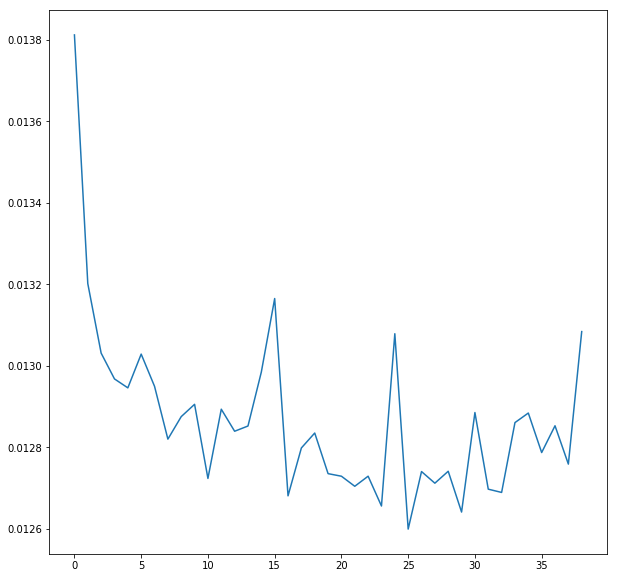

In [14]:
plt.figure( figsize = (10, 10))
plt.plot(mean_test_loss)
plt.show()

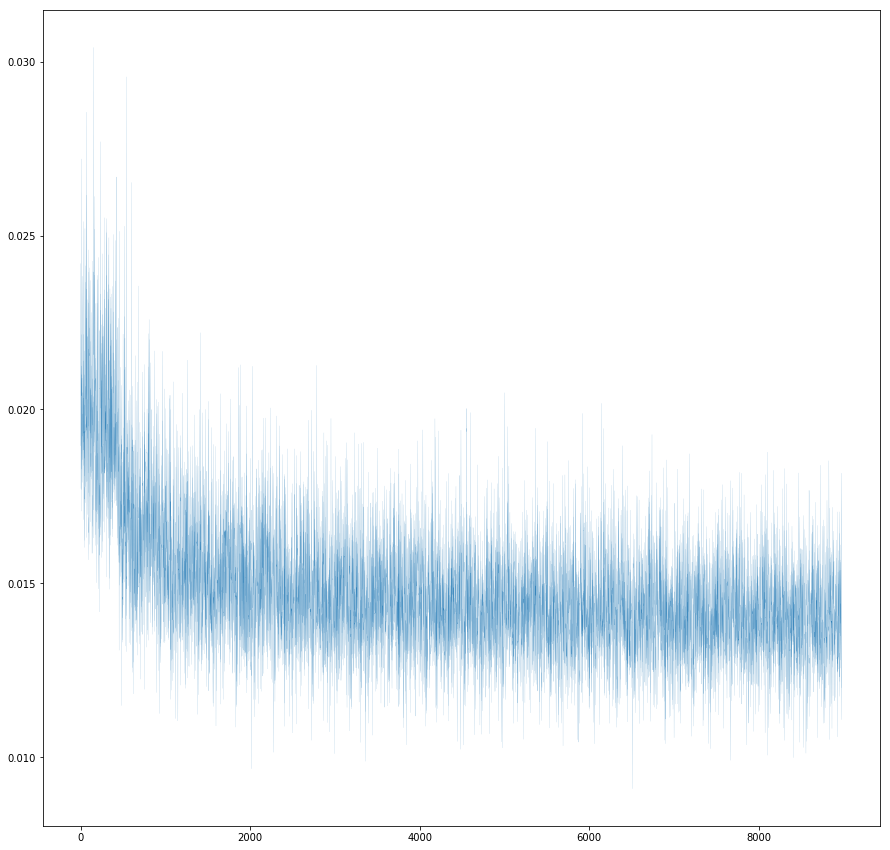

In [14]:
plt.figure( figsize = (15, 15))
plt.plot(test_loss, linewidth=0.1)
plt.show()